In [1]:
import os, re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

In [2]:
BASE_DIR = "input/"
columns = ['Text', 'Class']
base = pd.DataFrame(columns=columns)

In [3]:
dfs = []
for file in os.listdir(BASE_DIR):
    path = os.path.join(BASE_DIR, file)
    df = pd.read_csv(path, sep='\t+', header=None, names=columns)
    dfs.append(df)
base = pd.concat(dfs, ignore_index=True)

/Users/_joelvieira/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(base.Text, 
                                                    base.Class, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [5]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [6]:
def preprocessing(doc):
    # Convert text to lowercase
    doc = doc.lower()
    # Numbers remove
    doc = re.sub(r'\d+', '', doc)
    # Punctuation remove
    import string
    doc = doc.translate(str.maketrans('','',string.punctuation))
    # Spaces remove
    doc = doc.strip()
    # Stop words remove
    stop_words = set(stopwords.words('english'))  
    tokens = word_tokenize(doc)
    result = [i for i in tokens if not i in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    result = [stemmer.stem(word) for word in result]
    # Custom stop words remove
    custom_stop_words = ['phone', 'product', 'headset', 'sound', 'batteri', 'ear', 'price', 'case', 
        'servic', 'bluetooth', ] + ['food', 'place', 'restaur', 'pizza'] + ['movi', 'film', 'stori', 'script', 
        'scene', 'charact'] 
    result = [i for i in result if not i in custom_stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(word) for word in result]
    return result

In [7]:
vect = CountVectorizer(analyzer=preprocessing)
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

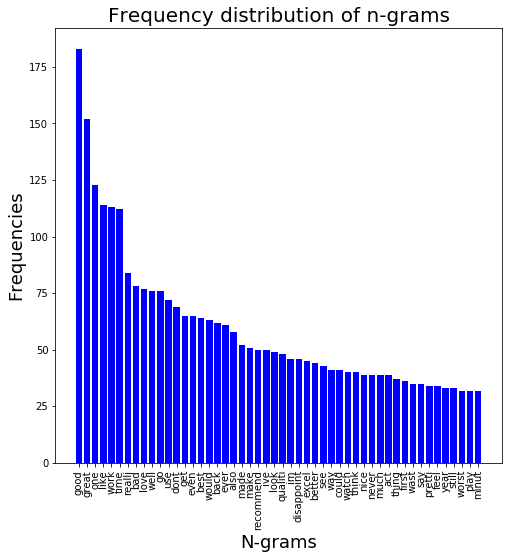

In [8]:
num_ngrams = 50
all_ngrams = list(vect.get_feature_names())
num_ngrams = min(num_ngrams, len(all_ngrams))
all_counts = tf_train.sum(axis=0).tolist()[0]
all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
ngrams = list(all_ngrams)[:num_ngrams]
counts = list(all_counts)[:num_ngrams]

idx = np.arange(num_ngrams)

fig = plt.figure(figsize=(8, 8)) 
plt.bar(idx, counts, width=0.8, color='b')
plt.xlabel('N-grams', fontsize=18)
plt.ylabel('Frequencies', fontsize=18)
plt.title('Frequency distribution of n-grams', fontsize=20)
plt.xticks(idx, ngrams, rotation=90, fontsize=10)
plt.show()

In [9]:
param_grid = {'C': [0.1, 0.5, 1, 5, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(tf_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 0.5, 1, 5, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [10]:
grid.best_estimator_

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [11]:
y_pred = grid.predict(tf_test)

In [12]:
accuracy_score(y_test, y_pred)

0.8066666666666666

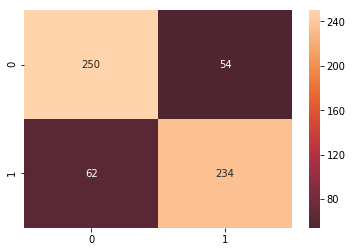

In [13]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, center=0, fmt="d")

In [14]:
df = pd.DataFrame()
df['Features'] = vect.get_feature_names()
df['Importance'] = grid.best_estimator_.coef_[0]
df['Positive'] = df['Importance'] > 0
df.sort_values(by=['Importance'], inplace=True, ascending=False)

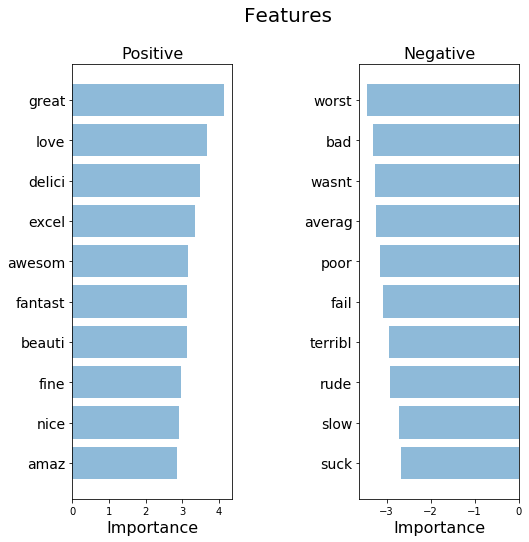

In [15]:

pos_features = df[df.Positive == True]['Features'][:10]
neg_features = df[df.Positive == False]['Features'][-10:]

pos_importance = df[df.Positive == True]['Importance'][:10]
neg_importance = df[df.Positive == False]['Importance'][-10:]

y_pos = np.arange(10)

fig = plt.figure(figsize=(8, 8))  

plt.subplot(121)
plt.barh(y_pos, pos_importance, align='center', alpha=0.5)
plt.title('Positive', fontsize=16)
plt.yticks(y_pos, pos_features, fontsize=14)
plt.gca().invert_yaxis()
plt.suptitle('Features', fontsize=20)
plt.xlabel('Importance', fontsize=16)
    
plt.subplot(122)
plt.barh(y_pos, neg_importance, align='center', alpha=0.5)
plt.title('Negative', fontsize=16)
plt.yticks(y_pos, neg_features, fontsize=14)
plt.xlabel('Importance', fontsize=16)
    
plt.subplots_adjust(wspace=0.8)
plt.show()

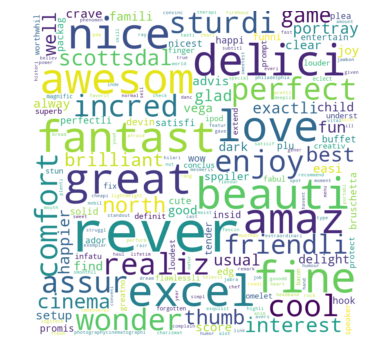

In [16]:
text = " ".join(review for review in df[df.Positive == True]['Features'])

wordcloud = WordCloud(background_color="white", width=800, height=800,max_font_size=140)
wordcloud.generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

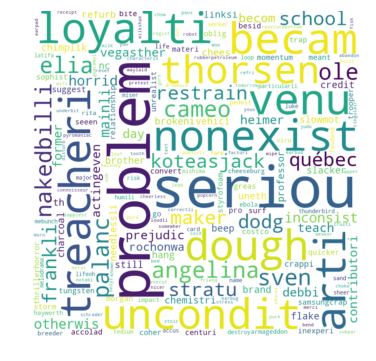

In [17]:
text = " ".join(review for review in df[df.Positive == False]['Features'])

wordcloud = WordCloud(background_color="white", width=800, height=800,max_font_size=140)
wordcloud.generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()